I came across [@realtimebus](https://twitter.com/realtimebus) the other day and immediately wanted to recreate is for Vancouver. Luckily [Translink has a realtime bus API](https://developer.translink.ca/) that I could pull from and making an animated gif is pretty straightforward in Python. And since I already have some experience making twitter bots with [@VanBikeShareBot](https://twitter.com/VanBikeShareBot) so I felt like I didn't really have a choice.

<!-- TEASER_END-->

First I needed to go to the Translink developers website to get an API key, and put it in a file called `credentials.py` like so:
```
translink_api_key = 'myapikeystring'
```
This allows me to import the key as a variable without making it public.

In [1]:
from credentials import translink_api_key

The first step is to write a function that queries the API and dumps the bus information to a CSV file. My strategy here is to read the XML from the API call and convert it to a Pandas dataframe which gets saved as a CSV. The first call creates the CSV file and subsequent queries append to the end of the file.

In [2]:
import urllib.request
import xml.etree.ElementTree as ET
import pandas as pd
import datetime
import time

In [3]:
def query():

    try:
        df = pd.read_csv('buses.csv')
    except:
        df = pd.DataFrame()

    # Query Translink API
    u = f"http://api.translink.ca/rttiapi/v1/buses?apikey={translink_api_key}"

    attnames = ['VehicleNo','TripId','RouteNo',
                'Direction','Pattern','RouteMap','Latitude','Longitude','RecordedTime','Href']

    with urllib.request.urlopen(u) as url:
        data = url.read().decode()
        buses = ET.fromstring(data)
        ndf = pd.DataFrame()
        for bus in buses:
            atts = [att.text for att in bus]
            atts = {name:att for name,att in zip(attnames,atts)}
            ndf = ndf.append(atts,ignore_index=True)


        ndf.RecordedTime = pd.to_datetime(ndf.RecordedTime)
        ndf.Latitude = ndf.Latitude.astype(float)
        ndf.Longitude = ndf.Longitude.astype(float)
        ndf = ndf[ndf.Latitude!=0]  # Drop lats/long == 0

    df = df.append(ndf)
    df = df.drop_duplicates()

    df.to_csv('buses.csv',index=False)

For my project I run this function once a minute. For this exercice we just need to run it a few times to get some data. Let's query the API 5 times before moving on.

In [4]:
for i in range(5):
    print('query')
    query()
    time.sleep(60)

query
query
query
query
query


Now we've built up some data, but it's in a fairly messy form. We need to transform the dataframe into something we can cycle through to make an animations.

In [5]:
df = pd.read_csv('buses.csv')
df.head()

,Direction,Href,Latitude,Longitude,Pattern,RecordedTime,RouteMap,RouteNo,TripId,VehicleNo
0,WEST,NaN,49.234800,-123.186233,UBC,2019-02-16 21:31:27,WB1,49,10210880,12001
1,WEST,NaN,49.224150,-122.999967,UBC,2019-02-16 21:31:21,WB1,49,10210889,12003
2,WEST,NaN,49.225383,-123.083500,UBC,2019-02-16 21:31:27,WB1,49,10210851,12016
3,EAST,NaN,49.265750,-122.778250,PT COQ STN,2019-02-16 21:31:22,EB1PC,160,10224133,14002
4,WEST,NaN,49.279817,-122.794150,COQ CTRL STN,2019-02-16 21:30:23,WB2,188,10227563,14006


My goal now is to conver the dataframe such that each row is a timepoint and each column is an individual bus, with the values being the location coordinates. For simplicity I'm also going to break out latitude and longitude into separate dataframes.

In [28]:
latdf = pd.pivot_table(df,index='RecordedTime',values='Latitude',columns='VehicleNo',aggfunc='first')
longdf = pd.pivot_table(df,index='RecordedTime',values='Longitude',columns='VehicleNo',aggfunc='first')

In [8]:
latdf.head()

VehicleNo,1503,1509,1510,1511,1515,1516,1517,1518,1519,1520,...,18506,18508,18509,18524,80705,80903,80906,80909,81205,81210
RecordedTime,,,,,,,,,,,,,,,,,,,,,
2019-02-16 21:19:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-02-16 21:20:12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-02-16 21:21:53,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-02-16 21:22:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-02-16 21:22:49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
latdf[1503].dropna()

RecordedTime
2019-02-16 21:31:14    49.261317
2019-02-16 21:31:50    49.260883
2019-02-16 21:33:15    49.263033
2019-02-16 21:34:26    49.265217
2019-02-16 21:35:17    49.265367
2019-02-16 21:46:30    49.275183
Name: 1503, dtype: float64

The dataframe looks empty but it's really just sparse. Each bus has a different "RecordedTime" value, the last time which it reported its location to Translink's servers. What I want to do it first reindex the dataframe so that the index is continuous through the timeframe we're looking at, then interpolate the coordinates for each bus along each columns. The interpolation needs to be run on floats not tuples which is why I separated out the lats and longs, but I'll recombine them into `coordsdf` once the interpolation is done.

In [29]:
df.RecordedTime = pd.to_datetime(df.RecordedTime)
idx = pd.date_range(df.RecordedTime.min(),df.RecordedTime.max(),freq='s')

In [36]:
latdf = latdf.reindex(idx)
longdf = longdf.reindex(idx)

In [37]:
latdf_interp = latdf.interpolate(method='time',limit_direction='both')
longdf_interp = longdf.interpolate(method='time',limit_direction='both')

In [38]:
latdf_interp.head()

VehicleNo,1503,1509,1510,1511,1515,1516,1517,1518,1519,1520,...,18506,18508,18509,18524,80705,80903,80906,80909,81205,81210
2019-02-16 21:19:06,49.261317,49.2798,49.206667,49.2011,49.214817,49.217083,49.21485,49.0363,49.224,49.259633,...,49.32845,49.328433,49.374467,49.200333,49.34105,49.3367,49.374083,49.281467,49.327833,49.2867
2019-02-16 21:19:07,49.261317,49.2798,49.206667,49.2011,49.214817,49.217083,49.21485,49.0363,49.224,49.259633,...,49.32845,49.328433,49.374467,49.200333,49.34105,49.3367,49.374083,49.281467,49.327833,49.2867
2019-02-16 21:19:08,49.261317,49.2798,49.206667,49.2011,49.214817,49.217083,49.21485,49.0363,49.224,49.259633,...,49.32845,49.328433,49.374467,49.200333,49.34105,49.3367,49.374083,49.281467,49.327833,49.2867
2019-02-16 21:19:09,49.261317,49.2798,49.206667,49.2011,49.214817,49.217083,49.21485,49.0363,49.224,49.259633,...,49.32845,49.328433,49.374467,49.200333,49.34105,49.3367,49.374083,49.281467,49.327833,49.2867
2019-02-16 21:19:10,49.261317,49.2798,49.206667,49.2011,49.214817,49.217083,49.21485,49.0363,49.224,49.259633,...,49.32845,49.328433,49.374467,49.200333,49.34105,49.3367,49.374083,49.281467,49.327833,49.2867


In [39]:
coordsdf = latdf_interp.combine(longdf_interp,lambda x,y: tuple(zip(y,x)))

# We don't actually need a data point for each second to make a smooth
# GIF, so let's only keep every 10th row.
coordsdf = coordsdf.iloc[::10]

In [40]:
coordsdf.head()

VehicleNo,1503,1509,1510,1511,1515,1516,1517,1518,1519,1520,...,18506,18508,18509,18524,80705,80903,80906,80909,81205,81210
2019-02-16 21:19:06,"(-122.774217, 49.261317)","(-123.137633, 49.2798)","(-123.017883, 49.206667)","(-122.91175, 49.2011)","(-122.990033, 49.214817)","(-122.921933, 49.217083)","(-122.99095, 49.21485)","(-123.068583, 49.0363)","(-122.9997, 49.224)","(-123.25515, 49.259633)",...,"(-123.15748300000001, 49.32845)","(-122.99675, 49.328433)","(-123.27725, 49.374467)","(-122.9123, 49.200333)","(-123.135633, 49.34105)","(-123.189683, 49.3367)","(-123.2729, 49.374083)","(-123.113967, 49.281467)","(-123.1538, 49.327833)","(-123.12465, 49.2867)"
2019-02-16 21:19:16,"(-122.774217, 49.261317)","(-123.137633, 49.2798)","(-123.017883, 49.206667)","(-122.91175, 49.2011)","(-122.990033, 49.214817)","(-122.921933, 49.217083)","(-122.99095, 49.21485)","(-123.068583, 49.0363)","(-122.9997, 49.224)","(-123.25515, 49.259633)",...,"(-123.15748300000001, 49.32845)","(-122.99675, 49.328433)","(-123.27725, 49.374467)","(-122.9123, 49.200333)","(-123.135633, 49.34105)","(-123.189683, 49.3367)","(-123.2729, 49.374083)","(-123.113967, 49.281467)","(-123.1538, 49.327833)","(-123.12465, 49.2867)"
2019-02-16 21:19:26,"(-122.774217, 49.261317)","(-123.137633, 49.2798)","(-123.017883, 49.206667)","(-122.91175, 49.2011)","(-122.990033, 49.214817)","(-122.921933, 49.217083)","(-122.99095, 49.21485)","(-123.068583, 49.0363)","(-122.9997, 49.224)","(-123.25515, 49.259633)",...,"(-123.15748300000001, 49.32845)","(-122.99675, 49.328433)","(-123.27725, 49.374467)","(-122.9123, 49.200333)","(-123.135633, 49.34105)","(-123.189683, 49.3367)","(-123.2729, 49.374083)","(-123.113967, 49.281467)","(-123.1538, 49.327833)","(-123.12465, 49.2867)"
2019-02-16 21:19:36,"(-122.774217, 49.261317)","(-123.137633, 49.2798)","(-123.017883, 49.206667)","(-122.91175, 49.2011)","(-122.990033, 49.214817)","(-122.921933, 49.217083)","(-122.99095, 49.21485)","(-123.068583, 49.0363)","(-122.9997, 49.224)","(-123.25515, 49.259633)",...,"(-123.15748300000001, 49.32845)","(-122.99675, 49.328433)","(-123.27725, 49.374467)","(-122.9123, 49.200333)","(-123.135633, 49.34105)","(-123.189683, 49.3367)","(-123.2729, 49.374083)","(-123.113967, 49.281467)","(-123.1538, 49.327833)","(-123.12465, 49.2867)"
2019-02-16 21:19:46,"(-122.774217, 49.261317)","(-123.137633, 49.2798)","(-123.017883, 49.206667)","(-122.91175, 49.2011)","(-122.990033, 49.214817)","(-122.921933, 49.217083)","(-122.99095, 49.21485)","(-123.068583, 49.0363)","(-122.9997, 49.224)","(-123.25515, 49.259633)",...,"(-123.15748300000001, 49.32845)","(-122.99675, 49.328433)","(-123.27725, 49.374467)","(-122.9123, 49.200333)","(-123.135633, 49.34105)","(-123.189683, 49.3367)","(-123.2729, 49.374083)","(-123.113967, 49.281467)","(-123.1538, 49.327833)","(-123.12465, 49.2867)"


This is something I can work with! I'll start by drawing a static scatter plot of the first row of our dat

<IPython.core.display.Javascript object>


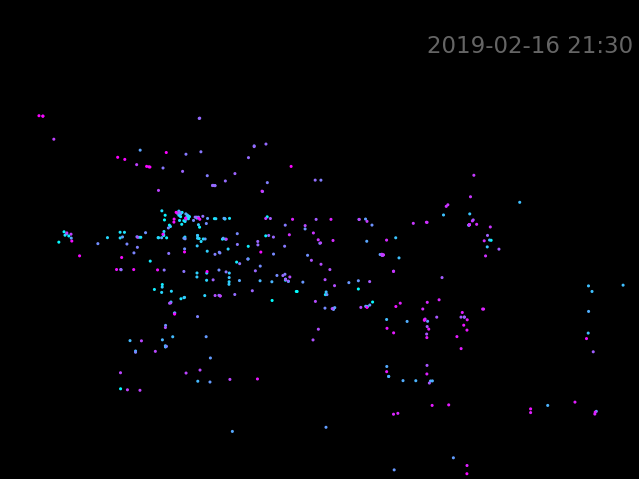

In [42]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
%matplotlib notebook

f,ax = plt.subplots()
ax.set_facecolor('k')
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
f.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)

In [43]:
longs = coordsdf.iloc[0].map(lambda x: x[0])
lats =  coordsdf.iloc[0].map(lambda x: x[1])

longmin = -123.3206 # Horseshoe bay
longmax = -122.5374 # Langley-ish
latmin = 49.0       # US Border/Ferry terminal
latmax = 49.479576  # Lions Bay
ax.set_xlim(longmin,longmax)
ax.set_ylim(latmin,latmax)

scatter = ax.scatter(longs,lats,s=1,cmap='cool',c=range(len(coordsdf.columns)))
text = ax.text(0.9,0.9,str(coordsdf.index[0])[:16],size=15,
                         color='white',alpha=0.4,transform=ax.transAxes,horizontalalignment='right')

Finally to turn this into an animation I have to define a function that will be run in sequence to create each frame. I just need to pull the latitudes and longitudes from the next row in our dataframe, update the scatter plot and update the timestamp text.

To create the animation `FuncAnimation` just needs the original figure handle, the update function, the number of frames and the time interval between frames. We want one frame for each row in the dataframe, and I found that a 50 ms frame rate gives a nice smooth appearance, but for this short demonstration I'll slow it down to 100ms.

In [44]:
def run(i):

    longs = coordsdf.iloc[i].map(lambda x: x[0])
    lats =  coordsdf.iloc[i].map(lambda x: x[1])

    scatter.set_offsets(list(zip(longs,lats)))
    text.set_text(str(coordsdf.index[i])[:16])

In [45]:
frames=len(coordsdf)
ani = animation.FuncAnimation(f,run,frames=frames, interval=100)
ani.save('buses_animation.gif',writer='imagemagick') 

![](/images/buses_animation.gif)

You might notice that most of the buses stay still for the first few seconds. This is because a few buses are more delayed in updating their position, so they have an earlier `RecordedTime` value than the other buses. The interpolation function keeps buses in the same spot until they start having measured coordinates. 

It's up to you whether you want to create a GIF or an mp4 video file. If you prefer mp4, you might want to use the `ffmpeg` writer instead of `imagemagick`. Videos have the advantage of smaller file sizes, but I'm having some trouble upload mp4s through the twitter API so I'm sticking with GIFs for now. 

The final code for my twitter bot available on [Github](https://github.com/mjarrett/VanBusBot). It's organized slightly differently to make it easier to run as cron jobs, but the guts are exactly the same as what's described here. If you have any questions about this project, don't hesitate to get in touch via [twitter](https://twitter.com/mikejarrett_) or [email](mike@mikejarrett.ca).